In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:98% !important; }</style>")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import contextily as cx
from rasterio.crs import CRS
from pathlib import Path
import pickle
from shapely.geometry import Polygon, Point, box
import pandas as pd
from geopandas import gpd
import numpy as np

In [4]:
# helper functions

# the below two functions help grid the data into 1 degree by 1 degree boxes
def get_lat(geom):
    return int(np.floor(geom.centroid.coords.xy[1][0]))
def get_lon(geom):
    return int(np.floor(geom.centroid.coords.xy[0][0]))

# creates the 1 degree by 1 degree box
def make_box(row):
    return box(row['lon'], row['lat'], row['lon'] + 1, row['lat'] + 1)

In [5]:
def calculate_averages(results: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    results['lat_lon_str'] = results.apply(lambda row: str(row['center_x']) + '_' + str(row['center_y']), axis=1)
    
    df = pd.DataFrame(columns = ['av_cad_days','avail_sensors','n_avail_sensors'])
    
    df['av_cad_days'] = [results[results.lat_lon_str == i].cadence.mean().total_seconds()/(3600 * 24) for i in results.lat_lon_str.unique()]
    df['avail_sensors'] = [results[results.lat_lon_str == i].sensor.unique() for i in results.lat_lon_str.unique()]
    df['n_avail_sensors'] = [len(results[results.lat_lon_str == i].sensor.unique()) for i in results.lat_lon_str.unique()]
    geometry = [Point(float(i.split('_')[0]), float(i.split('_')[1])) for i in results.lat_lon_str.unique()]
    df = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS.from_epsg(4326))
    
    return df

In [6]:
# Re-grid results to 1x1 degree cells
def regrid(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    df_temp['lon'] = df_temp.geometry.map(get_lon)
    df_temp['lat'] = df_temp.geometry.map(get_lat)
    
    return df_temp

# Use geodataframe groupby function to aggregate rows to 1 by 1 degree box
def aggregator(df_temp: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df_ag = df_temp.copy()
    geom = df_ag.apply(make_box, axis=1)
    df_ag = gpd.GeoDataFrame(df_ag,
                             geometry=geom,
                             crs = CRS.from_epsg(4326))
    return df_ag

In [7]:
# main function, transforms dataframe of search results to plot dataframe
def get_boxes(results: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    
    df = calculate_averages(results)
    df = regrid(df)
    df_ag = aggregator(df)
    
    return df_ag

In [8]:
# filters search results according to sensors
def separate_sensors(results: gpd.GeoDataFrame, sensor: list) -> gpd.GeoDataFrame:
    
    df = results[results.sensor.isin(sensor)].reset_index(drop=True)
    df['cadence'] = df.groupby(['center_x','center_y'])['startTime'].transform(lambda x: x.diff())
    df.reset_index(drop=True,inplace=True)
    
    return df

In [450]:
output_path = Path('../output_dfs')
dfs = sorted(list(output_path.glob('*_results.pkl')))
print(dfs)

[PosixPath('../output_dfs/Africa_results.pkl'), PosixPath('../output_dfs/Asia_results.pkl'), PosixPath('../output_dfs/Europe_results.pkl'), PosixPath('../output_dfs/North America_results.pkl'), PosixPath('../output_dfs/Oceania_results.pkl'), PosixPath('../output_dfs/South America_results.pkl')]


In [13]:
output_path = Path('../output_dfs')
dfsa = sorted(list(output_path.glob('*condense11_results.pkl')))
print(dfsa)
with open(dfsa[0], 'rb') as f:
    africa_condense11 = pickle.load(f)

[PosixPath('../output_dfs/Africa_condense11_results.pkl')]


In [451]:
continent_list = ['Africa','Asia','Europe','N_America','Oceania','S_America']
continents = {}
for i in range(len(continent_list)):
    with open(dfs[i], 'rb') as f:
        continents[continent_list[i]] = pickle.load(f)

In [488]:
df_africa = get_boxes(continents['Africa'])

In [ ]:
df_asia = get_boxes(continents['Asia'])

In [ ]:
df_europe = get_boxes(continents['Europe'])

In [468]:
df_namerica = get_boxes(continents['N_America'])

In [ ]:
df_samerica = get_boxes(continents['S_America'])

In [ ]:
df_oceania = get_boxes(continents['Oceania'])

In [14]:
df_africa_condense11 = get_boxes(africa_condense11)

### Plotting functions

Text(0.5, 1.0, 'Africa Coverage Cadence in Days during 2022 Jan')

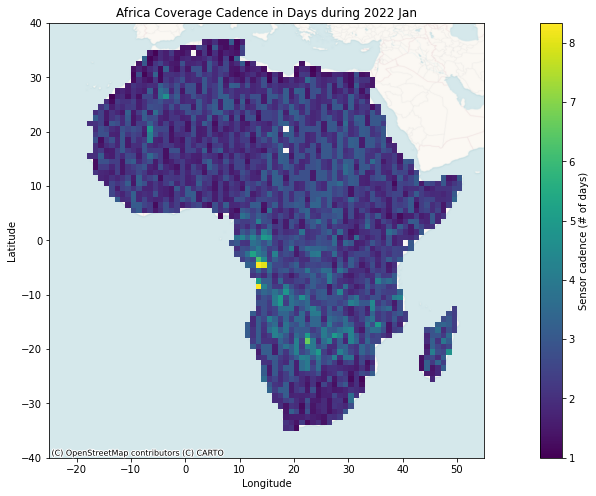

In [472]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-25,55)
ax.set_ylim(-40,40)
df.plot(column='av_cad_days', ax=ax, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Africa Coverage Cadence in Days during 2022 Jan')

Text(0.5, 1.0, 'Africa Coverage Cadence in Days during 2022 Jan')

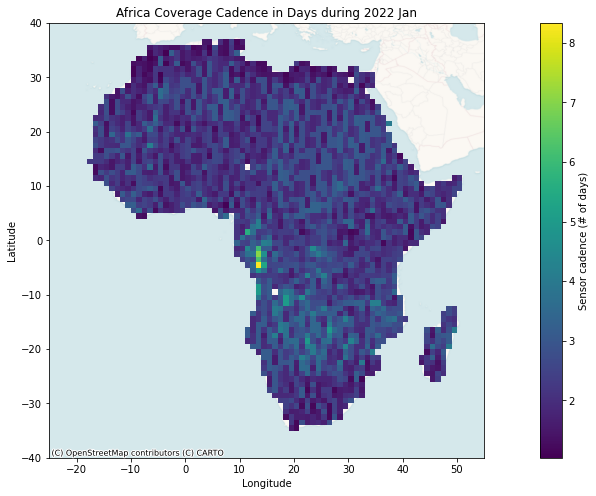

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-25,55)
ax.set_ylim(-40,40)
df_africa_condense.plot(column='av_cad_days', ax=ax, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Africa Coverage Cadence in Days during 2022 Jan')

In [464]:
# Generate dataframe for only sentinel-2 and landsat8 over Africa
test_df = separate_sensors(continents['Africa'], ['sentinel2','landsat8'])
test1_df = get_boxes(test_df)

Text(0.5, 1.0, 'Africa Coverage Cadence in Days during 2022 Jan (Sentinel-2 and Landsat8 only)')

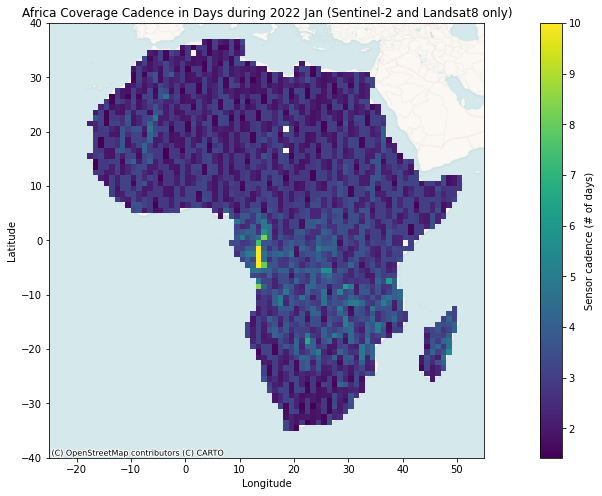

In [473]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-25,55)
ax.set_ylim(-40,40)
test1_df.plot(column='av_cad_days', vmax = 10, ax=ax, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Africa Coverage Cadence in Days during 2022 Jan (Sentinel-2 and Landsat8 only)')

In [469]:
# Generate dataframe for only sentinel-1 over Africa
test2_df = separate_sensors(continents['Africa'], ['sentinel1'])
test2_df = get_boxes(test2_df)

Text(0.5, 1.0, 'Africa Coverage Cadence in Days during 2022 Jan (Sentinel-1 only)')

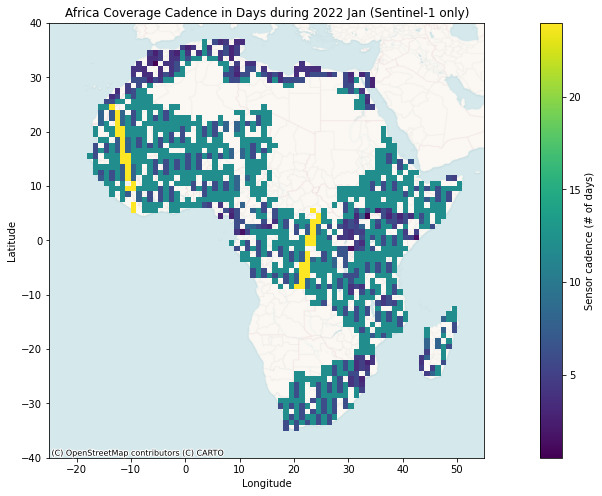

In [474]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-25,55)
ax.set_ylim(-40,40)
test2_df.plot(column='av_cad_days', ax=ax, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Africa Coverage Cadence in Days during 2022 Jan (Sentinel-1 only)')

In [ ]:
df_asia = get_boxes(continents['Asia'])

Text(0.5, 1.0, 'Asia Coverage Cadence in Days')

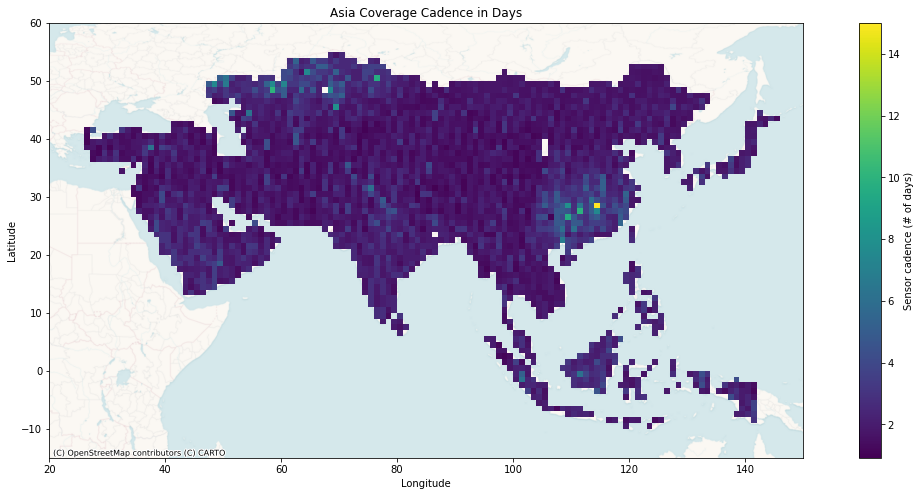

In [242]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(20,150)
ax.set_ylim(-15,60)
df_asia.plot(column='av_cad_days', ax=ax, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Asia Coverage Cadence in Days')

In [243]:
df_europe = get_boxes(continents['Europe'])

Text(0.5, 1.0, 'Europe Coverage Cadence in Days')

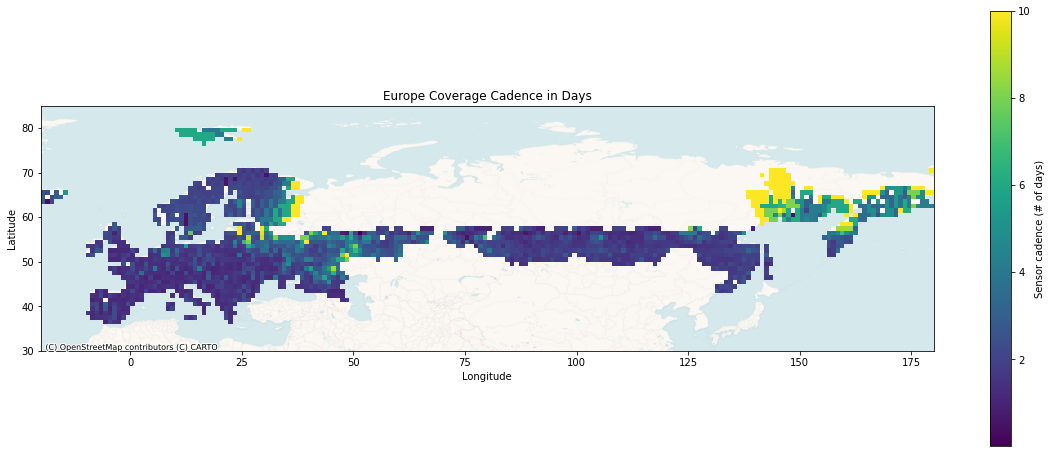

In [487]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-20,180)
ax.set_ylim(30,85)
df_europe.plot(column='av_cad_days', ax=ax, vmax=10, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Europe Coverage Cadence in Days')

Text(0.5, 1.0, 'North America Coverage Cadence in Days')

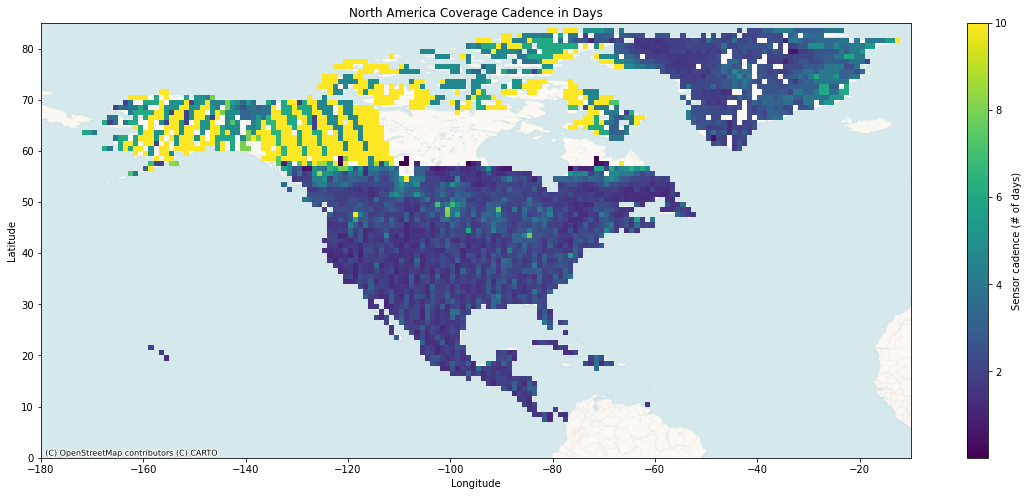

In [477]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-180,-10)
ax.set_ylim(0,85)
df_namerica.plot(column='av_cad_days', ax=ax, vmax = 10, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('North America Coverage Cadence in Days')

In [250]:
df_samerica = get_boxes(continents['S_America'])

Text(0.5, 1.0, 'South America Coverage Cadence in Days')

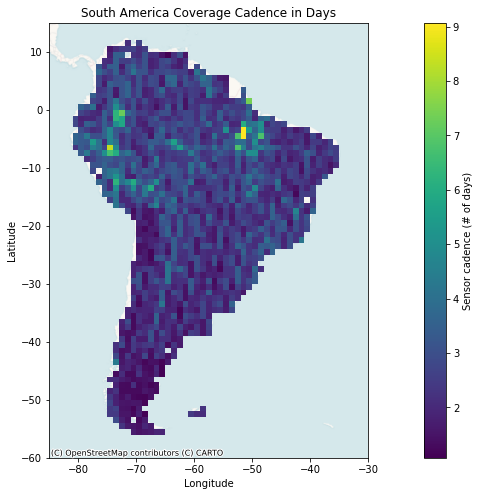

In [259]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-85,-30)
ax.set_ylim(-60,15)
df_samerica.plot(column='av_cad_days', ax=ax, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('South America Coverage Cadence in Days')

In [254]:
df_oceania = get_boxes(continents['Oceania'])

Text(0.5, 1.0, 'Oceania Coverage Cadence in Days')

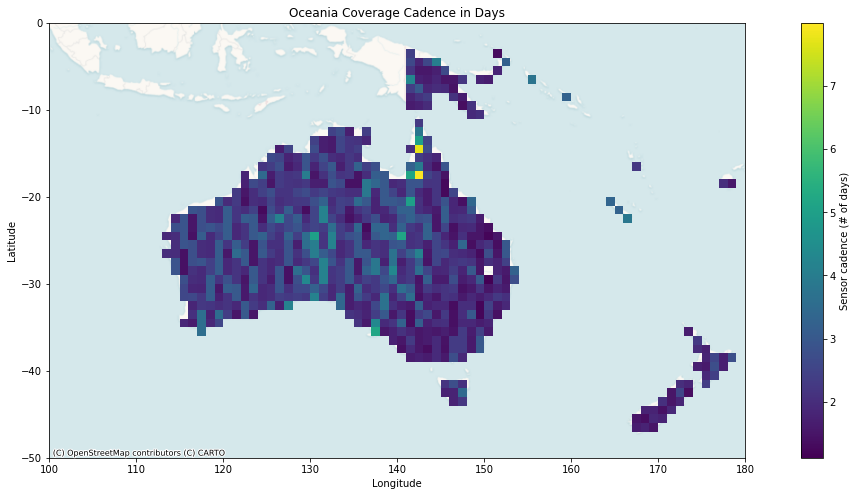

In [257]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(100,180)
ax.set_ylim(-50,0)
df_oceania.plot(column='av_cad_days', ax=ax, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Oceania Coverage Cadence in Days')

In [289]:
global_df = pd.concat([df_asia,df_africa,df_namerica,df_samerica,df_oceania,df_europe])

Text(0.5, 1.0, 'Global Coverage Cadence (Sentinel-1, Sentinel-2, Landsat-8) in Days during 2022-01-01 - 2022-02-01')

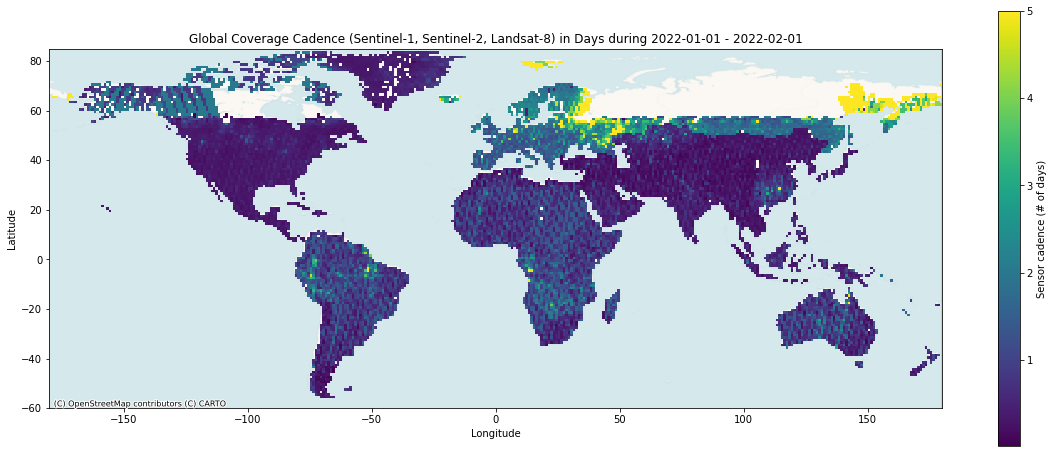

In [486]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlim(-180,180)
ax.set_ylim(-60,85)
global_df.plot(column='av_cad_days', ax=ax, vmax = 5, legend=True, legend_kwds={'label': "Sensor cadence (# of days)"})
cx.add_basemap(ax=ax,crs='EPSG:4326',source=cx.providers.CartoDB.VoyagerNoLabels)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Global Coverage Cadence (Sentinel-1, Sentinel-2, Landsat-8) in Days during 2022 Jan')

Text(0.5, 1.0, 'Histogram binned by Average Cadence in Days')

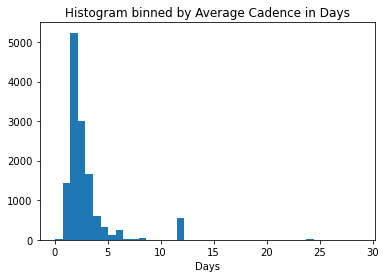

In [302]:
plt.hist(global_df.av_cad_days, bins=40)
plt.xlabel('Days')
plt.title('Histogram binned by Average Cadence in Days')

Text(0.5, 1.0, 'Histogram binned by Average Cadence in Days')

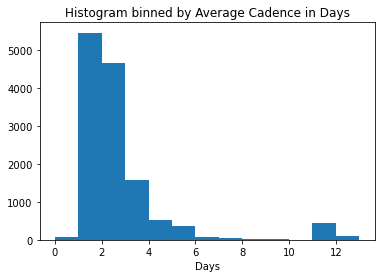

In [312]:
plt.hist(global_df.av_cad_days, bins = 13, range = (0,13))
plt.xlabel('Days')
plt.title('Histogram binned by Average Cadence in Days')

In [313]:
results_list=list(continents.values())
global_results = pd.concat(results_list)

Text(0.5, 1.0, 'Histogram binned by Latitude')

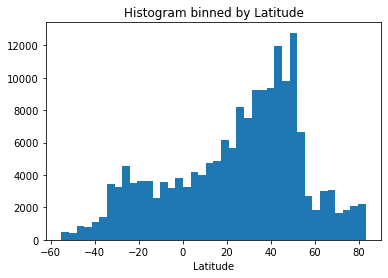

In [318]:
plt.hist(global_results.center_y, bins = 40)
plt.xlabel('Latitude')
plt.title('Histogram binned by Latitude')

Text(0.5, 1.0, 'Histogram binned by Average Cadence in Days')

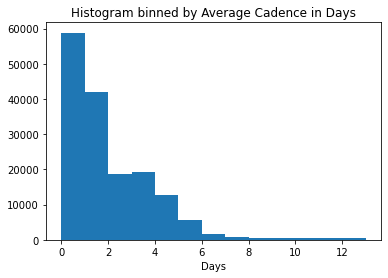

In [327]:
cadence = [i.total_seconds() / (3600 * 24) for i in global_results.cadence]
plt.hist(cadence, bins = 13, range = (0,13))
plt.xlabel('Days')
plt.title('Histogram binned by Average Cadence in Days')

In [334]:
sensors = ['Sentinel-1','Sentinel-2','Landsat-8']
sent1 = [i.total_seconds() / (3600 * 24) for i in global_results[global_results.sensor == 'sentinel1'].cadence]
sent2 = [i.total_seconds() / (3600 * 24) for i in global_results[global_results.sensor == 'sentinel2'].cadence]
land8 = [i.total_seconds() / (3600 * 24) for i in global_results[global_results.sensor == 'landsat8'].cadence]
data = [sent1, sent2, land8]

Text(0.5, 1.0, 'Average cadence in Days by Sensor')

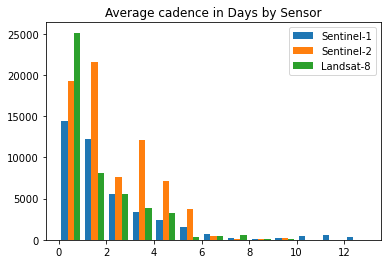

In [340]:
plt.hist(data, bins = 13, range = (0,13), label=sensors)
plt.legend(prop={'size': 10})
plt.title('Average cadence in Days by Sensor')

Text(0.5, 1.0, 'Histogram binned by Longitude by Sensor')

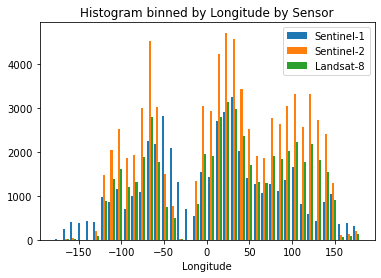

In [343]:
sensors = ['Sentinel-1','Sentinel-2','Landsat-8']
data = [global_results[global_results.sensor == 'sentinel1'].center_x, global_results[global_results.sensor == 'sentinel2'].center_x, global_results[global_results.sensor == 'landsat8'].center_x]
plt.hist(data, bins = 40, label=sensors)
plt.legend(prop={'size': 10})
plt.xlabel('Longitude')
plt.title('Histogram binned by Longitude by Sensor')

Text(0.5, 1.0, 'Histogram binned by Latitude by Sensor over Africa')

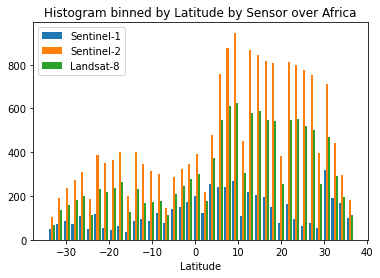

In [432]:
sensors = ['Sentinel-1','Sentinel-2','Landsat-8']
data = [continents['Africa'][continents['Africa'].sensor == 'sentinel1'].center_y, continents['Africa'][continents['Africa'].sensor == 'sentinel2'].center_y, continents['Africa'][continents['Africa'].sensor == 'landsat8'].center_y]
plt.hist(data, bins = 40, label=sensors)
plt.legend(prop={'size': 10})
plt.xlabel('Latitude')
plt.title('Histogram binned by Latitude by Sensor over Africa')

Text(0.5, 1.0, 'Histogram binned by Latitude by Sensor over Europe')

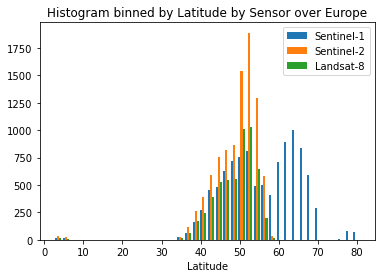

In [436]:
sensors = ['Sentinel-1','Sentinel-2','Landsat-8']
data = [continents['Europe'][continents['Europe'].sensor == 'sentinel1'].center_y, continents['Europe'][continents['Europe'].sensor == 'sentinel2'].center_y, continents['Europe'][continents['Europe'].sensor == 'landsat8'].center_y]
plt.hist(data, bins = 40, label=sensors)
plt.legend(prop={'size': 10})
plt.xlabel('Latitude')
plt.title('Histogram binned by Latitude by Sensor over Europe')

Text(0.5, 1.0, 'Histogram binned by Latitude by Sensor')

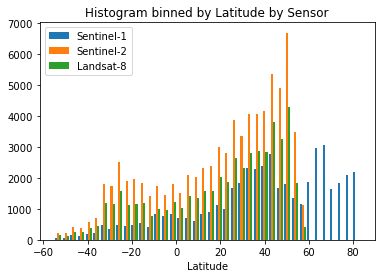

In [344]:
sensors = ['Sentinel-1','Sentinel-2','Landsat-8']
data = [global_results[global_results.sensor == 'sentinel1'].center_y, global_results[global_results.sensor == 'sentinel2'].center_y, global_results[global_results.sensor == 'landsat8'].center_y]
plt.hist(data, bins = 40, label=sensors)
plt.legend(prop={'size': 10})
plt.xlabel('Latitude')
plt.title('Histogram binned by Latitude by Sensor')

Text(0.5, 1.0, 'Acquisition Latitudes vs Average Cadence in Days')

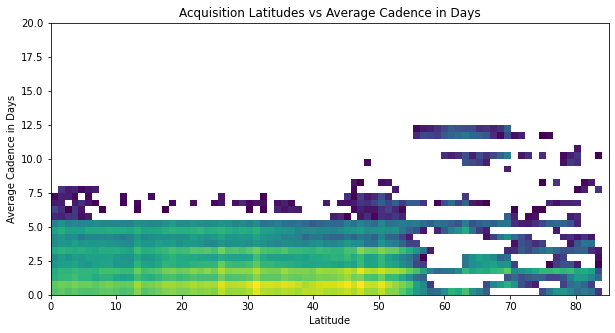

In [402]:
import matplotlib as mpl
plt.figure(figsize=(10,5))
plt.hist2d(np.abs(global_results.center_y), cadence, bins = [80,40], range = [[0, 85], [0, 20]], cmin = 10, norm=mpl.colors.LogNorm())
plt.xlabel('Latitude')
plt.ylabel('Average Cadence in Days')
plt.title('Acquisition Latitudes vs Average Cadence in Days')

In [421]:
lat_range = (-60,80)
bins = lat_range[1] - lat_range[0] + 1

In [424]:
from scipy.stats import binned_statistic

lats,_,_ = binned_statistic(global_results.center_y, global_results.center_y, statistic=np.nanmean, range = lat_range, bins = bins)
means,_,_ = binned_statistic(global_results.center_y, cadence, statistic=np.nanmean, range = lat_range, bins = bins)
stds,_,_ = binned_statistic(global_results.center_y, cadence, statistic=np.nanstd, range = lat_range, bins = bins)

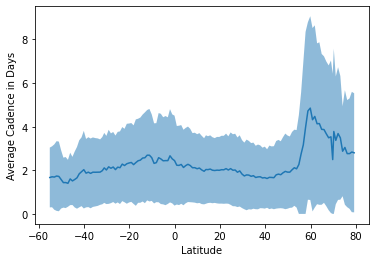

In [489]:
plt.fill_between(lats, np.maximum(means-stds,0), means+stds, alpha = 0.5)
plt.xlabel('Latitude')
plt.ylabel('Average Cadence in Days')
plt.plot(lats, means)

Text(0.5, 1.0, 'Acquisition Latitudes vs Average Cadence in Days (aggregated)')

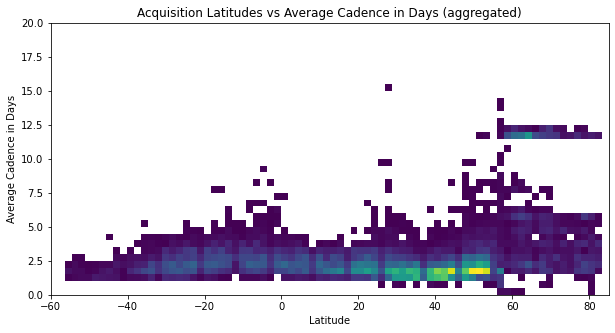

In [398]:
plt.figure(figsize=(10,5))
plt.hist2d(global_df.lat, global_df.av_cad_days, bins = [80,40], range = [[-60, 85], [0, 20]], cmin = 1)
plt.xlabel('Latitude')
plt.ylabel('Average Cadence in Days')
plt.title('Acquisition Latitudes vs Average Cadence in Days (aggregated)')